**Brain Tumor 3DSegmentation**

Workflow of multi-labels segmentation task
- Dataset gliomas active / Modal;ity Multimodal MRI / size 750 4D volumes (484 Training + 266 Testing)
- Process data in dictionary format perform trnsformations and data augmentation
- Cache IO and transformations to accelerate training and validation
- 3D Segmentation ResNet model / Challenge complex and heterogeneous-located targets
- Image patches whole tumor, tumor core, enhancing tumor structure surrounding cystic, and neocratic components
- The segmentations are combined to generate the final labels of the tumor of the sub-regions

In [ ]:
!pip install monai
!pip install monai-weekly
!pip install ignite
!python -c "import monai; print(monai.__version__)"
!python -c "import monai" || pip install -q "monai-weekly[nibabel, ignite, pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os, shutil, tempfile, PIL, logging, sys
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.apps import download_and_extract, DecathlonDataset
from monai.data import DataLoader, ImageDataset, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.config import print_config
from monai.transforms import (
    Activations, Activationsd, AsDiscrete, AsDiscreted, Compose, Invertd,
    LoadImaged, MapTransform, NormalizeIntensityd, Orientationd, RandFlipd,
    RandScaleIntensityd, RandShiftIntensityd, RandSpatialCropd, Spacingd,
    EnsureTyped, EnsureChannelFirstd )
from monai.utils import set_determinism
print_config()

In [ ]:
''' seed/deterministic training for reproduceability '''
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!mkdir monai
os.environ['monai'] = '/content/monai'
dir = os.environ.get('monai')
rootdir = tempfile.mkdtemp() if dir is None else dir
rootdir

'/content/monai'

In [ ]:
'''
Convert labels to multi-channels based on image classes
  - label 1 is the peritumoral edema
  - label 2 is the GC-enhancing tumor
  - label 3 is the necrotic and non-enhancing tumor core
The possible classes are tumor core TC, whole tumor WT, and enhancing tumor ET
'''
class convert_to_multi_channel(MapTransform):
  def __call__(self, data):
    d_ = dict(data)
    for key in self.keys:
        result = []
        ''' merge label 2 and label 3 to construct tumor core '''
        result.append(torch.logical_or(d_[key] ==2, d_[key] ==3))
        ''' merge labels 1, 2 and 3 to construct whole tumor '''
        result.append(torch.logical_or(
            torch.logical_or(d_[key] ==2, d_[key] ==3), d_[key] == 1))
        ''' label 2 is enhanced tumor '''
        result.append(d_[key] == 2)
        d_[key] = torch.stack(result, axis=0).float()
    return d_

In [ ]:
train_transform = Compose([
  LoadImaged(keys=["image", "label"]), EnsureChannelFirstd(keys="image"),
  EnsureTyped(keys=["image", "label"]), convert_to_multi_channel(keys="label"),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"),),
  RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
  RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
  RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0), ])

In [ ]:
val_transform = Compose([
  LoadImaged(keys=["image", "label"]), EnsureChannelFirstd(keys="image"),
  EnsureTyped(keys=["image", "label"]), convert_to_multi_channel(keys="label"),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"),),
  RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0), ])

In [ ]:
''' Decathlon Dataset to download/extract and inherit Monai CacheDataset
configure cache num to N items for training and validation depending on mem size '''
train_ds = DecathlonDataset(
    root_dir=rootdir, task = 'Task01_BrainTumour', transform = train_transform,
    section = 'training', download = True, cache_rate =0.0, num_workers =4)

Task01_BrainTumour.tar: 7.09GB [06:43, 18.8MB/s]                            

2025-07-04 13:52:15,920 - INFO - Downloaded: /content/monai/Task01_BrainTumour.tar


2025-07-04 13:52:29,427 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-07-04 13:52:29,427 - INFO - Writing into directory: /content/monai.


In [ ]:
val_ds = DecathlonDataset(
    root_dir=rootdir, task = 'Task01_BrainTumour', transform = val_transform,
    section = 'validation', download = False, cache_rate =0.0, num_workers =4)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)

image shape: torch.Size([4, 240, 240, 155])


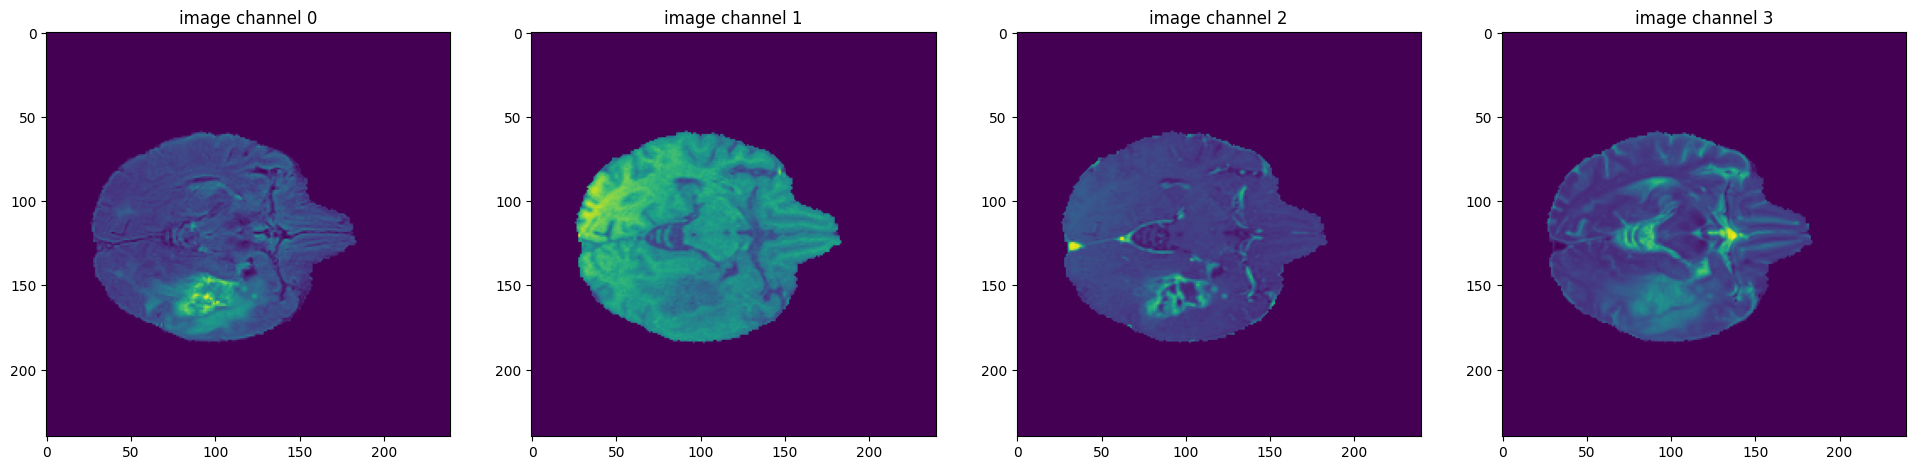

label shape: torch.Size([3, 240, 240, 155])


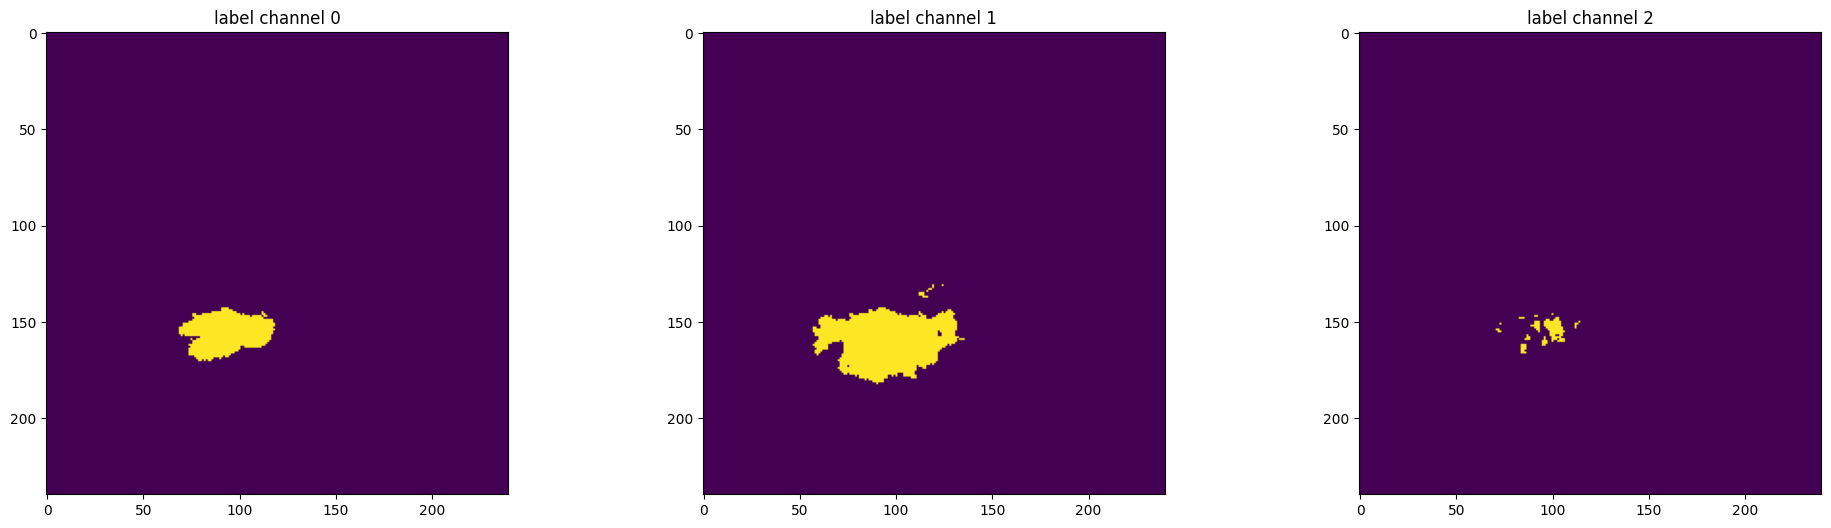

In [ ]:
''' visualization '''
val_sample = val_ds[20]
print(f"image shape: {val_sample['image'].shape}")
plt.figure('image', (24, 6))
for i in range(4):
  plt.subplot(1,4, i +1)
  plt.title(f'image channel {i}')
  plt.imshow(val_sample['image'][i, :, :, 60].detach().cpu())
plt.show()
print(f"label shape: {val_sample['label'].shape}")
plt.figure('image', (24, 6))
for i in range(3):
  plt.subplot(1,3, i +1)
  plt.title(f'label channel {i}')
  plt.imshow(val_sample['label'][i, :, :, 60].detach().cpu())

In [ ]:
''' Model, Loss and Optimizer '''
max_epochs = 300
val_interval =1
val_amp = True
model = SegResNet(blocks_down = [1, 2, 2, 4], blocks_up = [1, 1, 1],
    init_filters = 16, in_channels = 4, out_channels = 3, dropout_prob = 0.2
).to(device)
loss_function = DiceLoss(smooth_nr = 0, smooth_dr = 1e-5, squared_pred=True,
                  to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                  optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=True, reduction='mean')
dice_metric_batch = DiceMetric(include_background=True, reduction='mean_batch')
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [ ]:
''' Inference Method and use AMP to accelerate training'''
def inference(input):
  def _compute(input):
    return sliding_window_inference(inputs=input,
        roi_size=(240, 240, 160), sw_batch_size=1, predictor=model, overlap=.5 )

  if val_amp:
    with torch.cuda.amp.autocast():
      return _compute(input)
  else:
    return _compute(input)
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

/tmp/ipython-input-11-2521662504.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metric_epochs_and_time = [ [], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
import time

In [ ]:
''' Training loop in PyTorch reuse code as in templates '''
total_start = time.time()
for epoch in range(20): #max_epochs
  epoch_start = time.time()
  model.train()
  epoch_loss = 0 ; step = 0
  for batch_data in train_loader:
      step_start = time.time()
      step += 1
      inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
      optimizer.zero_grad()
      with torch.cuda.amp.autocast():
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      epoch_loss += loss.item()

  lr_scheduler.step()
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f'epoch {epoch +1} average loss: {epoch_loss:.4f}')

  if (epoch +1) % val_interval == 0:
    model.eval()
    with torch.no_grad():
      for val_data in val_loader:
        val_inputs, val_labels = (
            val_data['image'].to(device), val_data['label'].to(device) )
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

      metric = dice_metric.aggregate().item()
      metric_values.append(metric)
      metric_batch = dice_metric_batch.aggregate()
      metric_tc = metric_batch[0].item()
      metric_values_tc.append(metric_tc)
      metric_wt = metric_batch[1].item()
      metric_values_wt.append(metric_wt)
      metric_et = metric_batch[2].item()
      metric_values_et.append(metric_et)
      dice_metric.reset()
      dice_metric_batch.reset()

      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        best_metric_epochs_and_time[0].append(best_metric)
        best_metric_epochs_and_time[1].append(best_metric_epoch)
        best_metric_epochs_and_time[2].append(time.time() - total_start)
        torch.save(
            model.state_dict(), os.path.join(rootdir, 'best_metric_model.pth'))
  print(f'time consuming of epoch {epoch +1} is {(time.time() - epoch_start):.4f}')
total_time = time.time() - total_start

/tmp/ipython-input-51-1808382905.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


epoch 1 average loss: 0.1821
time consuming of epoch 1 is 412.2807
epoch 2 average loss: 0.1840


/tmp/ipython-input-11-2521662504.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


time consuming of epoch 2 is 462.7673
epoch 3 average loss: 0.1814
time consuming of epoch 3 is 411.8998
epoch 4 average loss: 0.1787
time consuming of epoch 4 is 462.3588
epoch 5 average loss: 0.1798
time consuming of epoch 5 is 411.6776
epoch 6 average loss: 0.1891
time consuming of epoch 6 is 463.4306
epoch 7 average loss: 0.1786
time consuming of epoch 7 is 411.5417
epoch 8 average loss: 0.1811
time consuming of epoch 8 is 463.3904
epoch 9 average loss: 0.1832
time consuming of epoch 9 is 412.1973
epoch 10 average loss: 0.1777
time consuming of epoch 10 is 462.7970
epoch 11 average loss: 0.1806
time consuming of epoch 11 is 411.5352


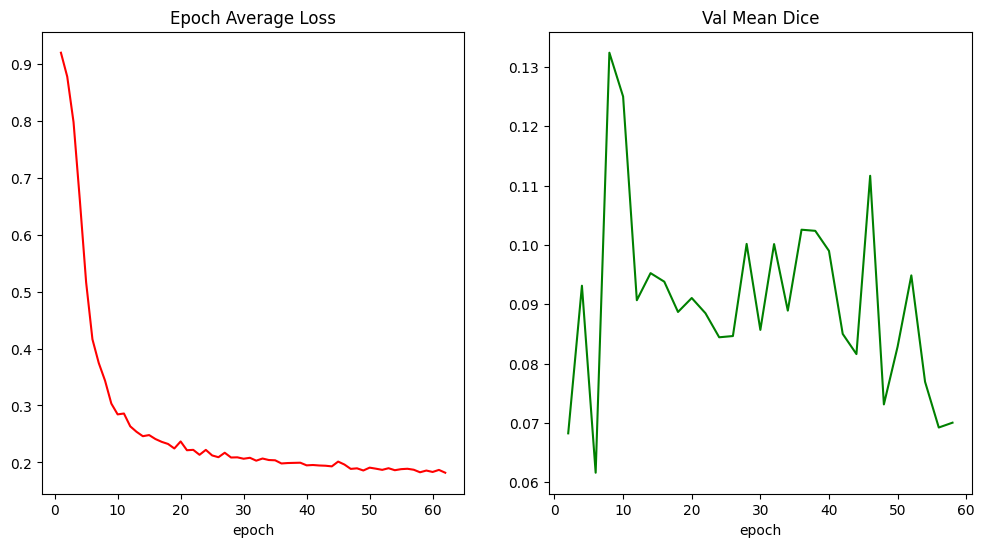

In [30]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

In [ ]:
model.eval()

/tmp/ipython-input-11-2521662504.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


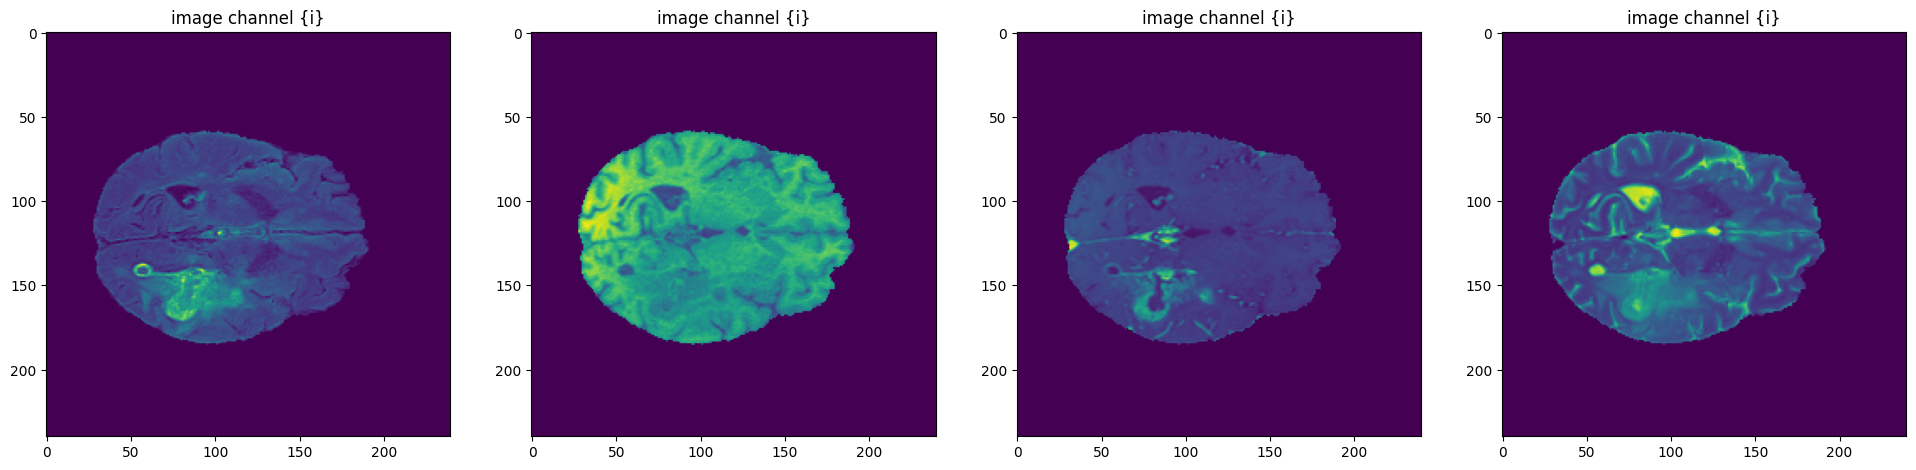

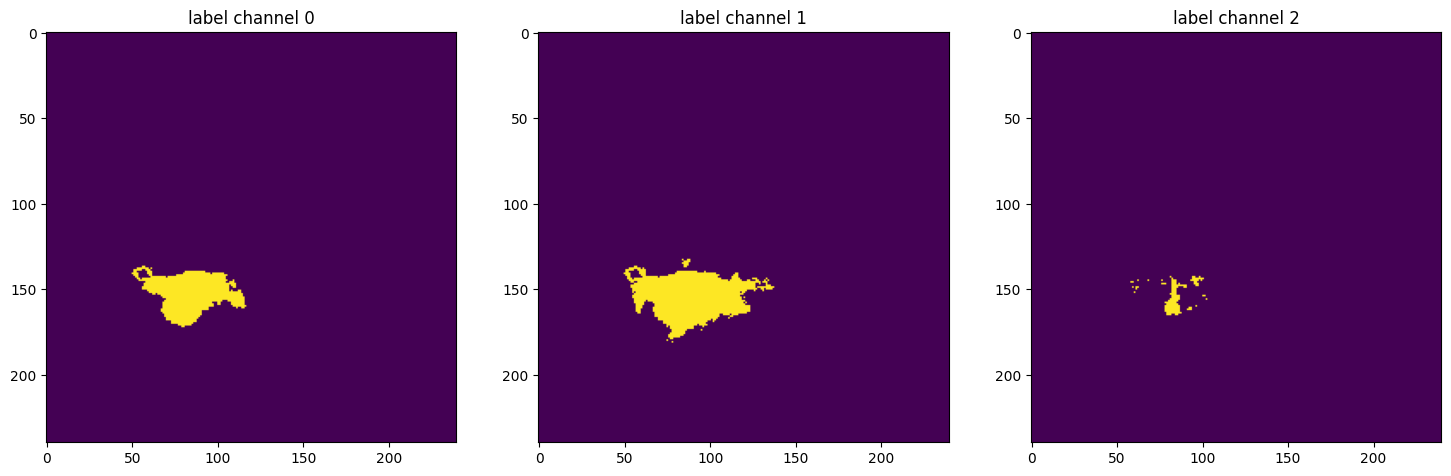

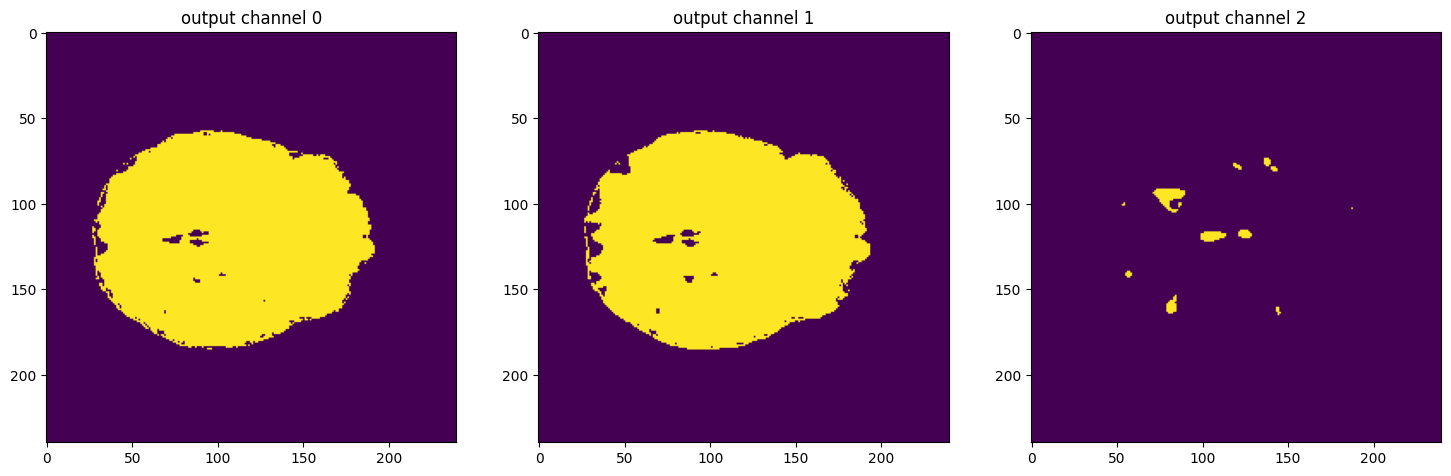

In [42]:
''' evaluate one sample and visualize '''
with torch.no_grad():
  val_input = val_ds[20]['image'].unsqueeze(0).to(device)
  roi_size = (128, 128, 64)
  sw_batch_size = 4
  val_output = inference(val_input)
  val_output = post_trans(val_output[0])
  plt.figure('image', (24, 6))
  for i in range(4):
    plt.subplot(1, 4, i +1)
    plt.title('image channel {i}')
    plt.imshow(val_ds[20]['image'][i, :, :, 70].detach().cpu())
  plt.show()
  plt.figure('label', (18, 6))
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f'label channel {i}')
    plt.imshow(val_ds[20]['label'][i, :, :, 70].detach().cpu())
  plt.show()
  plt.figure('output', (18, 6))
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f'output channel {i}')
    plt.imshow(val_output[i, :, :, 70].detach().cpu())
  plt.show()

In [48]:
''' evaluation on original image spacing '''
val_original_transform = Compose([
  LoadImaged(keys=["image", "label"]), EnsureChannelFirstd(keys="image"),
  EnsureTyped(keys=["image", "label"]), convert_to_multi_channel(keys="label"),
  Orientationd(keys=["image"], axcodes="RAS"),
  Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"),),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)
])

val_original_dataset = DecathlonDataset(root_dir=rootdir,
      task='Task01_BrainTumour', transform = val_original_transform,
      section = 'validation', download=False, num_workers=4, cache_num=0)

val_original_loader = DataLoader(
      val_original_dataset, batch_size=4, num_workers=4)

post_transforms = Compose([
    Invertd(keys='pred', transform = val_original_transform, orig_keys = 'image',
            meta_keys = 'pred_meta_dict', orig_meta_keys = 'image_meta_dict',
            meta_key_postfix = 'meta_dict', nearest_interp = False,
            to_tensor = True, device = 'cpu'),
    Activationsd(keys = 'pred', sigmoid=True),
    AsDiscreted(keys = 'pred', threshold =.5)
])

In [50]:
with torch.no_grad():
  for val_data in val_original_loader:
    val_inputs = val_data['image'].to(device)
    val_data['pred'] = inference(val_inputs)
    val_data = [post_transforms(i) for i in decollate_batch(val_data)]
    val_outputs, val_labels = from_engine(['pred', 'label'])(val_data)
    dice_metric(y_pred = val_outputs, y = val_labels)
    dice_metric_batch(y_pred = val_outputs, y = val_labels)

  metric_original = dice_metric.aggregate().item()
  metric_batch_org = dice_metric_batch.aggregate()
  dice_metric.reset()
  dice_metric_batch.reset()

metric_tc = metric_batch_org[0].item()
metric_wt = metric_batch_org[1].item()
metric_et = metric_batch_org[2].item()
f'metric original spacing, {metric_original}', \
f'metric_tc, {metric_tc}:.4f', f'metric_tc, {metric_wt}:.4f', \
f'metric_tc, {metric_et}:.4f'

/tmp/ipython-input-11-2521662504.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


('metric original spacing, 0.7645229697227478',
 'metric_tc, 0.8120529651641846:.4f',
 'metric_tc, 0.8986935615539551:.4f',
 'metric_tc, 0.5828223824501038:.4f')